Importing libraries, images and converting them to hsv

In [ ]:
import os
import cv2
import numpy as np
from matplotlib.image import imread
import matplotlib.pyplot as plt
import skimage
from skimage import img_as_ubyte
from skimage.color import rgb2gray
from skimage.color import gray2rgb
from skimage.filters import try_all_threshold
from skimage import filters

# Apply the Component analysis function

def ccfinder(img):
    # Find the connected components
    connectivity = 8
    output = cv2.connectedComponentsWithStats(img, connectivity, cv2.CV_32S)
    # Get the results
    # The first cell is the number of labels
    num_labels = output[0]
    # The second cell is the label matrix
    labels = output[1]
    # The third cell is the stat matrix
    stats = output[2]
    # The fourth cell is the centroid matrix
    centroids = output[3]
    return num_labels, labels, stats, centroids



In [138]:
#add img here
img1 = cv2.imread('gcnic.jpg',0)
img2 = cv2.imread('zaid.jpeg',0)
img3 =  cv2.imread('cnic_more_easy.jpeg',0)
img4 = cv2.imread('base_cnic.png',0)
img5 = cv2.imread('atash.jpg',0)
img6 = cv2.imread('atash2.jpg',0)
img7 = cv2.imread('cnic.jpg',0)

#add hsv of the image here
img1_to_hsv = cv2.cvtColor(cv2.imread('gcnic.jpg'), cv2.COLOR_BGR2HSV)
img2_to_hsv = cv2.cvtColor(cv2.imread('zaid.jpeg'), cv2.COLOR_BGR2HSV)
img3_to_hsv = cv2.cvtColor(cv2.imread('cnic_more_easy.jpeg'), cv2.COLOR_BGR2HSV)
img4_to_hsv = cv2.cvtColor(cv2.imread('base_cnic.png'), cv2.COLOR_BGR2HSV)
img5_to_hsv = cv2.cvtColor(cv2.imread('atash.jpg'), cv2.COLOR_BGR2HSV)
img6_to_hsv = cv2.cvtColor(cv2.imread('atash2.jpg'), cv2.COLOR_BGR2HSV)
img7_to_hsv = cv2.cvtColor(cv2.imread('cnic.jpg'), cv2.COLOR_BGR2HSV)

#include both the image and its hsv in the array
img = [img1,img2,img3,img4,img5,img6,img7]
img_to_hsv = [img1_to_hsv,img2_to_hsv,img3_to_hsv,img4_to_hsv,img5_to_hsv,img6_to_hsv,img7_to_hsv]

Applying bilateral filter and adaptive thresholding to the images

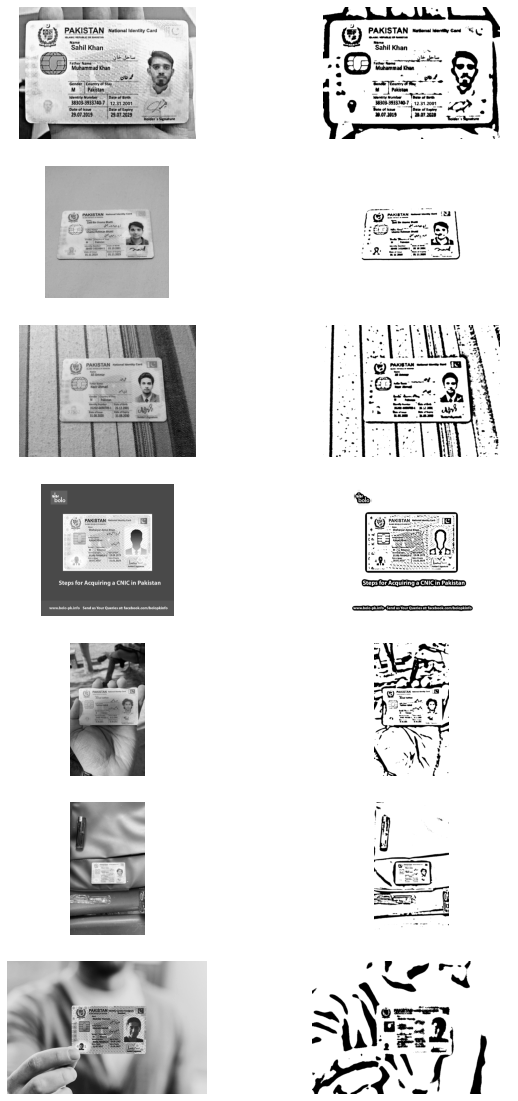

In [140]:
adp_th_bl = []

for i in img:
    temp = cv2.bilateralFilter(i, 15, 75, 75)
    adp_th_bl.append(cv2.adaptiveThreshold(temp,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,107,9))

fig = plt.figure(figsize=(10, 20))
# setting values to rows and column variables

rows = len(adp_th_bl)
columns = 2

count = 0
for i in range(len(adp_th_bl)):
    count+= 1
    fig.add_subplot(rows, columns, count)
    plt.imshow(img[i],'gray')
    plt.axis('off')
    count+=1
    fig.add_subplot(rows, columns, count)
    plt.imshow(adp_th_bl[i],'gray')
    plt.axis('off')

Extracting parts of images that lie in the renge of green hsv

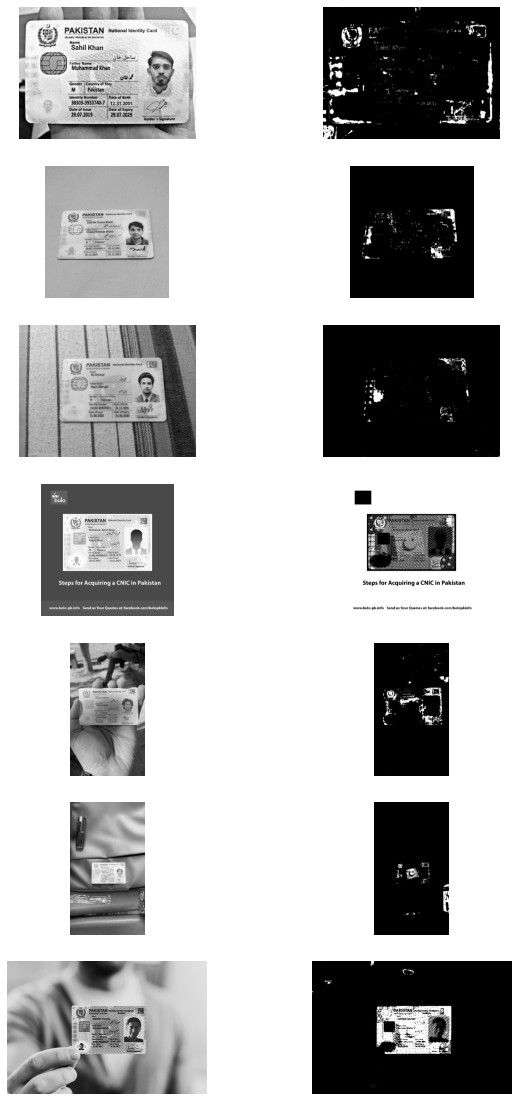

In [141]:
green_lower = np.array([36, 25, 25], np.uint8)
green_upper = np.array([86, 255, 255], np.uint8)

green_mask = []
for i in img_to_hsv:
    temp = cv2.inRange(i, green_lower, green_upper)
    green_mask.append(temp)
#     green_mask.append(cv2.inRange(temp, green_lower, green_upper))

fig = plt.figure(figsize=(10, 20))

rows = len(green_mask)
columns = 2

count = 0
for i in range(len(green_mask)):
    count+= 1
    fig.add_subplot(rows, columns, count)
    plt.imshow(img[i],'gray')
    plt.axis('off')
    count+=1
    fig.add_subplot(rows, columns, count)
    plt.imshow(green_mask[i],'gray')
    plt.axis('off')

Dilating the extracted green components until we get 5 biggest objects

In [142]:
dil_greens = []
for i in green_mask:
    dilgreen = i
    count = ccfinder(i)[0]
    while count > 5:
        count = ccfinder(dilgreen)[0]
        dilgreen = cv2.dilate(dilgreen, np.ones((3,3),np.uint8), iterations = 1)
    dil_greens.append(dilgreen)

Plotting 5 biggest dilated connected components from hsv mask 

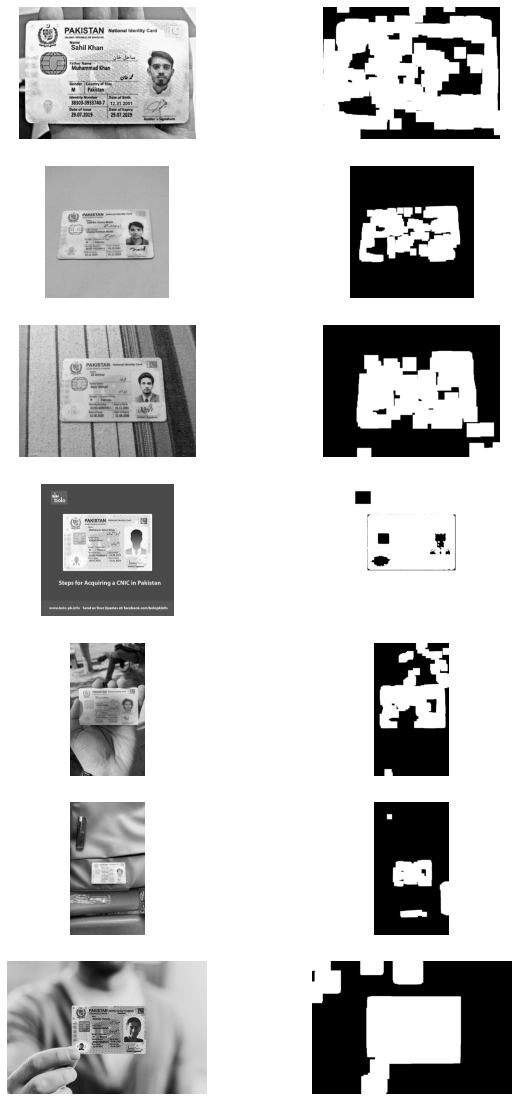

In [143]:
fig = plt.figure(figsize=(10, 20))
rows = len(dil_greens)
columns = 2
count = 0
for i in range(len(dil_greens)):
    count+= 1
    fig.add_subplot(rows, columns, count)
    plt.imshow(img[i],'gray')
    plt.axis('off')
    count+=1
    fig.add_subplot(rows, columns, count)
    plt.imshow(dil_greens[i],'gray')
    plt.axis('off')

Filtering the object from dilated green HSV mask with the greatest area


In [144]:
#Filtering the object from dilated green HSV mask with the greatest area
max_areas = []
for dil in dil_greens:
    analysis = cv2.connectedComponentsWithStats(dil,8,cv2.CV_32S)
    (totalLabels, label_ids, values, centroid) = analysis
    count = 0

    # Initialize a new image to store all the output components

    outputi = np.zeros(dil.shape, dtype="uint8")
    area = [] 
    labelids = []

    # Loop through each component
    for i in range(1, totalLabels):   
      # Area of the component
      area.append(values[i, cv2.CC_STAT_AREA])
      labelids.append(i)

    maxarea = max(area)
    maxindex = area.index(maxarea)
    maxlabel = labelids[maxindex]

    componentMask = (label_ids == maxlabel).astype("uint8") * 255
    outputi = cv2.bitwise_or(outputi, componentMask)
    max_areas.append(outputi)

Plotting the connected component with the biggest area from the filtered green hsv mask 

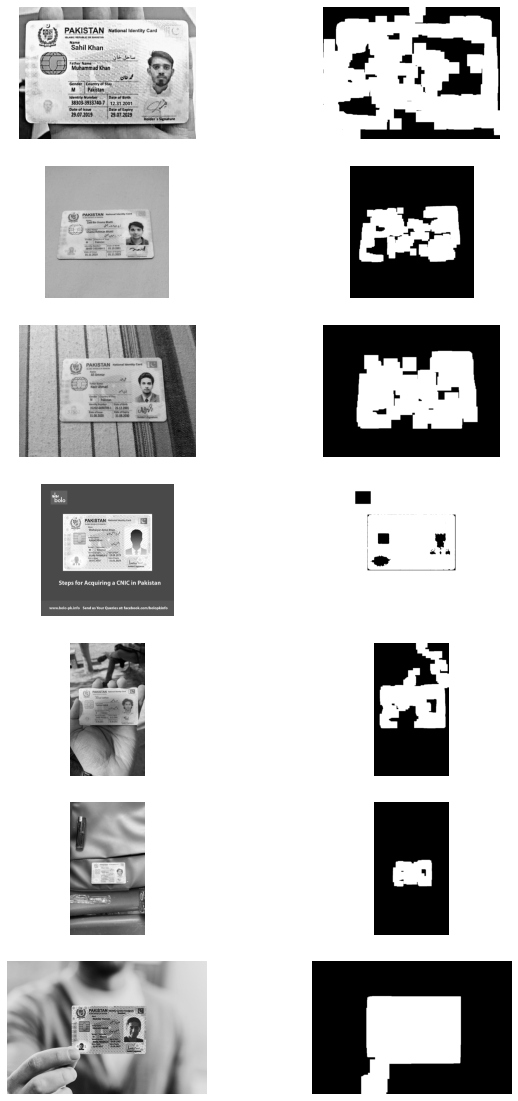

In [145]:
fig = plt.figure(figsize=(10, 20))

rows = len(max_areas)
columns = 2

count = 0
for i in range(len(max_areas)):
    count+= 1
    fig.add_subplot(rows, columns, count)
    plt.imshow(img[i],'gray')
    plt.axis('off')
    count+=1
    fig.add_subplot(rows, columns, count)
    plt.imshow(max_areas[i],'gray')
    plt.axis('off')

finding canny edges after dilation and erosion of the thresholded image 

In [146]:
#finding edges after dilation and erosion
kernel_de = np.ones((3, 3), np.uint8)
kernel = np.ones((5, 5), np.uint8)

eroded_img = []
for i in adp_th_bl:
    img_dilation = cv2.dilate(i, kernel_de, iterations=1)
    eroded_img.append(cv2.erode(img_dilation, kernel_de, iterations=1))

Dilating and closing the canny edges

In [147]:
edge_canny = []
for i in eroded_img:
    canny = cv2.Canny(i, 0, 255)
    canny = cv2.dilate(canny, None, iterations=1)
    canny = cv2.morphologyEx(canny, cv2.MORPH_CLOSE, kernel)
    edge_canny.append(canny)

Plotting the dilated and closed canny edges

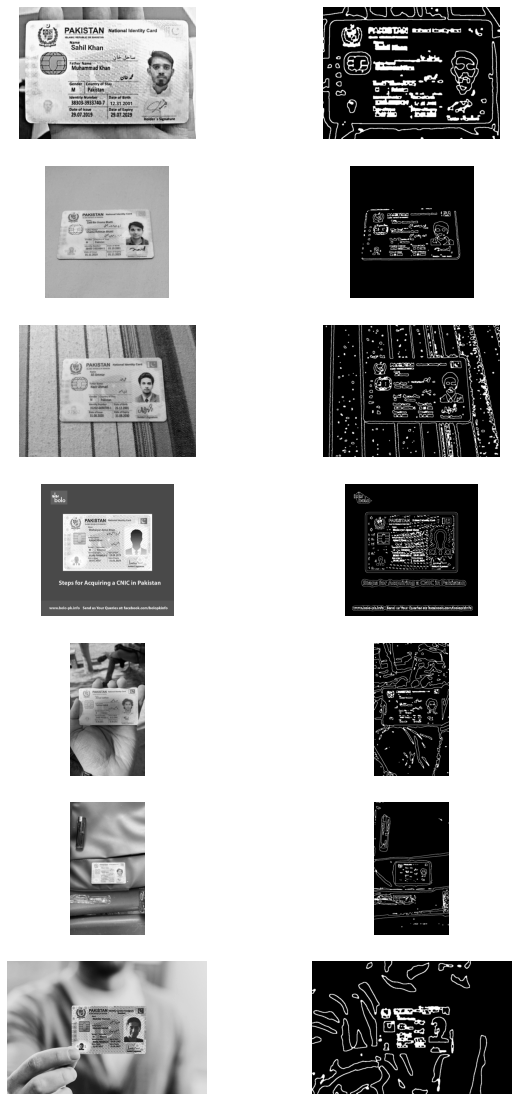

In [148]:
fig = plt.figure(figsize=(10, 20))

rows = len(edge_canny)
columns = 2

count = 0
for i in range(len(edge_canny)):
    count+= 1
    fig.add_subplot(rows, columns, count)
    plt.imshow(img[i],'gray')
    plt.axis('off')
    count+=1
    fig.add_subplot(rows, columns, count)
    plt.imshow(edge_canny[i],'gray')
    plt.axis('off')

Filtering the objects from dilated and closed canny edges with the areas > 500

In [149]:
#Filtering the objects from canny edges mask with the areas > 500
for can in edge_canny:
    analysis = cv2.connectedComponentsWithStats(can,8,cv2.CV_32S)
    (totalLabels, label_ids, values, centroid) = analysis
    count = 0
    # Initialize a new image to store
    # all the output components
    output = np.zeros(can.shape, dtype="uint8")

    # Loop through each component
    for i in range(1, totalLabels):
        # Area of the component
        area = values[i, cv2.CC_STAT_AREA]

        if (area > 500):
            componentMask = (label_ids == i).astype("uint8") * 255
            output = cv2.bitwise_or(output, componentMask)
    edge_canny[edge_canny.index(can)] = output

C:\Users\Game Boy\AppData\Local\Temp\ipykernel_3992\2716047278.py:18: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  edge_canny[edge_canny.index(can)] = output


Plotting the filtered canny edges

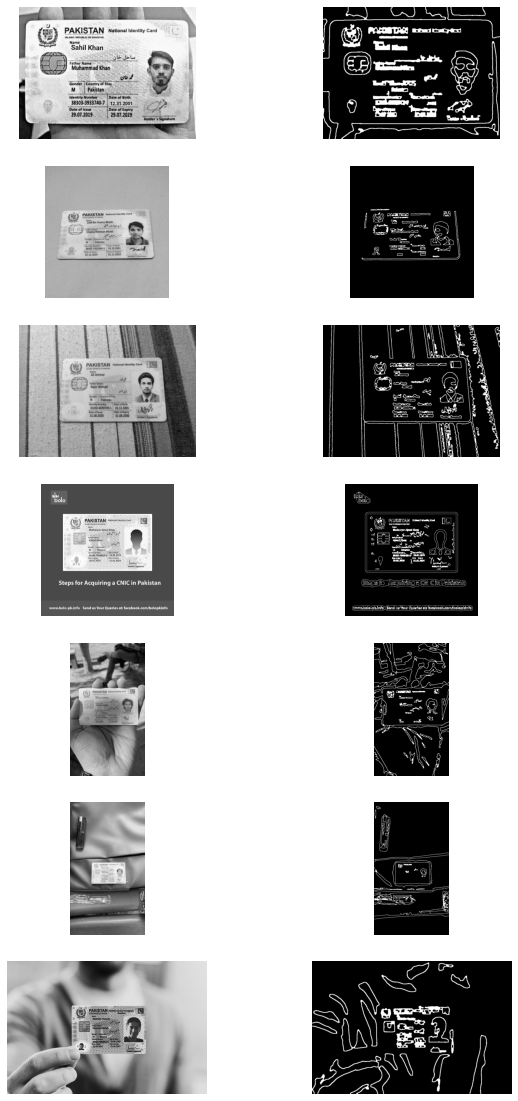

In [150]:
fig = plt.figure(figsize=(10, 20))

rows = len(edge_canny)
columns = 2

count = 0
for i in range(len(edge_canny)):
    count+= 1
    fig.add_subplot(rows, columns, count)
    plt.imshow(img[i],'gray')
    plt.axis('off')
    count+=1
    fig.add_subplot(rows, columns, count)
    plt.imshow(edge_canny[i],'gray')
    plt.axis('off')

1. dilating the canny edges with a 3x3 kernel and 10 iterations 
2. taking an intersection of the filtered canny edges and the filtered green hsv mask


In [151]:
intersection = []
for can in edge_canny:
    diloutput = cv2.dilate(can, np.ones((3,3),np.uint8), iterations=10)
    new_img = cv2.bitwise_and(diloutput,diloutput , mask=max_areas[edge_canny.index(can)])
    intersection.append(new_img)

C:\Users\Game Boy\AppData\Local\Temp\ipykernel_3992\2352284851.py:4: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  new_img = cv2.bitwise_and(diloutput,diloutput , mask=max_areas[edge_canny.index(can)])


Plotting the intersection of canny edges and green hsv mask

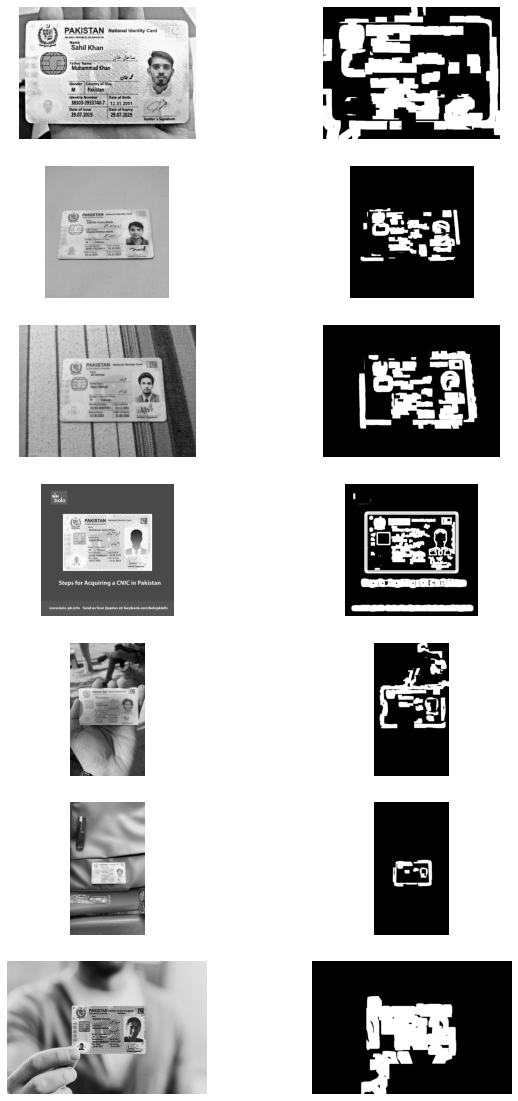

In [152]:
fig = plt.figure(figsize=(10, 20))

rows = len(intersection)
columns = 2

count = 0
for i in range(len(intersection)):
    count+= 1
    fig.add_subplot(rows, columns, count)
    plt.imshow(img[i],'gray')
    plt.axis('off')
    count+=1
    fig.add_subplot(rows, columns, count)
    plt.imshow(intersection[i],'gray')
    plt.axis('off')

Dilating the intersected components depending on the resolution of the source image

In [153]:
for i in range(len(intersection)):
    if intersection[i].shape[1] <= 1080:
        intersection[i] = cv2.dilate(intersection[i], None, iterations=15)
    elif intersection[i].shape[1] < 2160 and intersection[i].shape[1] > 1080:
        intersection[i] = cv2.dilate(intersection[i], None, iterations=25)    
    else:
        intersection[i] = cv2.dilate(intersection[i], None, iterations=75)

Plotting the dilated intersected components

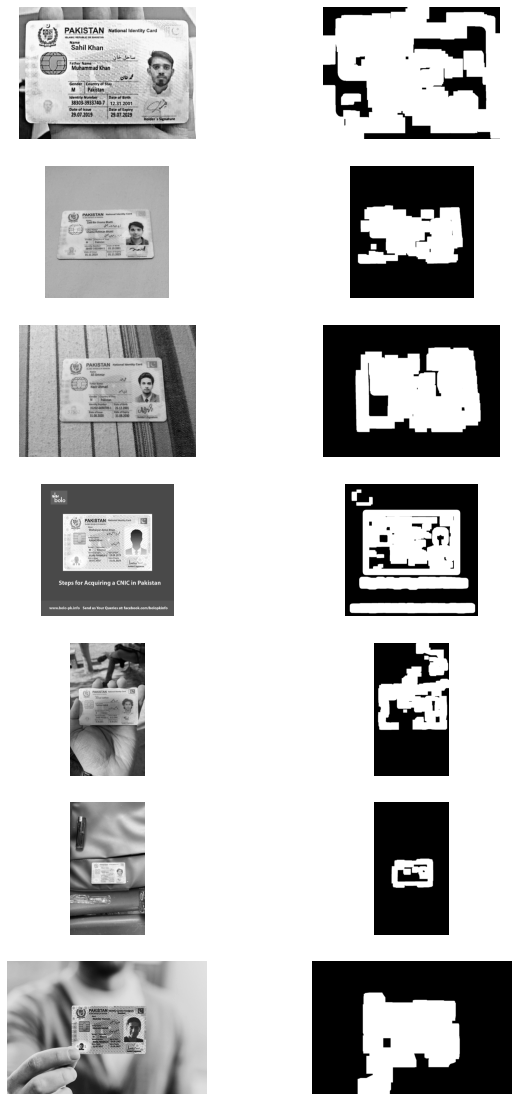

In [154]:
fig = plt.figure(figsize=(10, 20))

rows = len(intersection)
columns = 2

count = 0
for i in range(len(intersection)):
    count+= 1
    fig.add_subplot(rows, columns, count)
    plt.imshow(img[i],'gray')
    plt.axis('off')
    count+=1
    fig.add_subplot(rows, columns, count)
    plt.imshow(intersection[i],'gray')
    plt.axis('off')

Taking the corner points of the dilated intersected components and filling the region between them with a white color

In [155]:
result = []
for dili in intersection:
    contours, _ = cv2.findContours(dili, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    areasi = [cv2.contourArea(c) for c in contours]
    perimetersi = [cv2.arcLength(c, True) for c in contours]
    perimetersi = [round(x, 2) for x in perimetersi]
    
    def getExtremes(contour):
        leftmost = tuple(contour[contour[:,:,0].argmin()][0])
        rightmost = tuple(contour[contour[:,:,0].argmax()][0])
        topmost = tuple(contour[contour[:,:,1].argmin()][0])
        bottommost = tuple(contour[contour[:,:,1].argmax()][0])
        return leftmost, rightmost, topmost, bottommost

    leftmost, rightmost, topmost, bottommost = getExtremes(contours[areasi.index(max(areasi))])   
    leftmost = leftmost[0]
    rightmost = rightmost[0]
    topmost = topmost[1]
    bottommost = bottommost[1]
    
    for i in range(dili.shape[0]):
        for j in range(dili.shape[1]):
            if i <= topmost or i >= bottommost or j <= leftmost or j >= rightmost:
                dili[i,j] = 0
            else:
                dili[i,j] = 255    
    result.append(dili)

Plotting the results

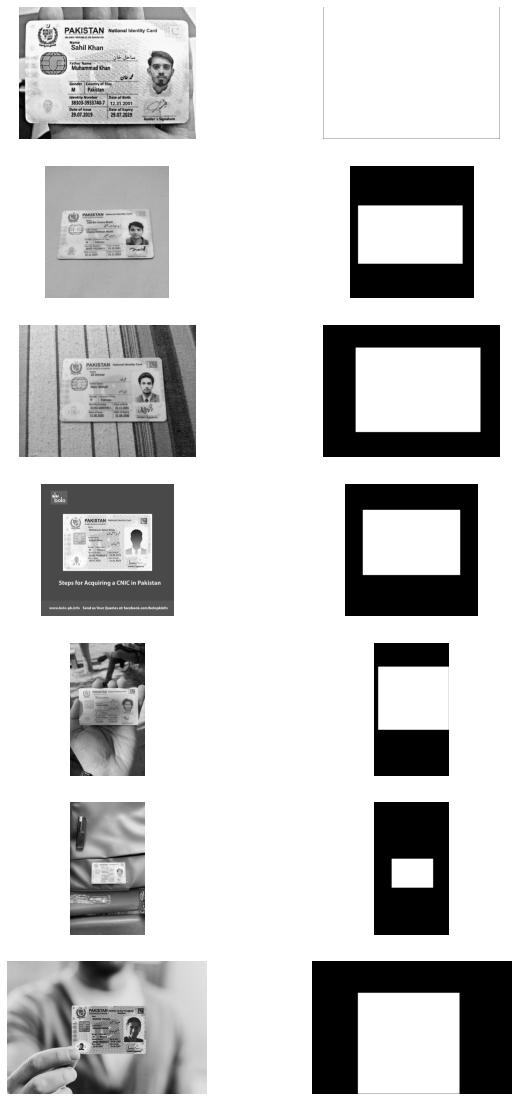

In [156]:
fig = plt.figure(figsize=(10, 20))

rows = len(result)
columns = 2

count = 0
for i in range(len(result)):
    count+= 1
    fig.add_subplot(rows, columns, count)
    plt.imshow(img[i],'gray')
    plt.axis('off')
    count+=1
    fig.add_subplot(rows, columns, count)
    plt.imshow(result[i],'gray')
    plt.axis('off')

Taking bitwise and of the dilated intersected components and the original image

In [157]:
band = []
for i in range(len(img)):
    band.append(cv2.bitwise_and(img[i], img[i], mask=result[i]))

Plotting the mask obtained from bitwise and of the dilated intersected components and the original image

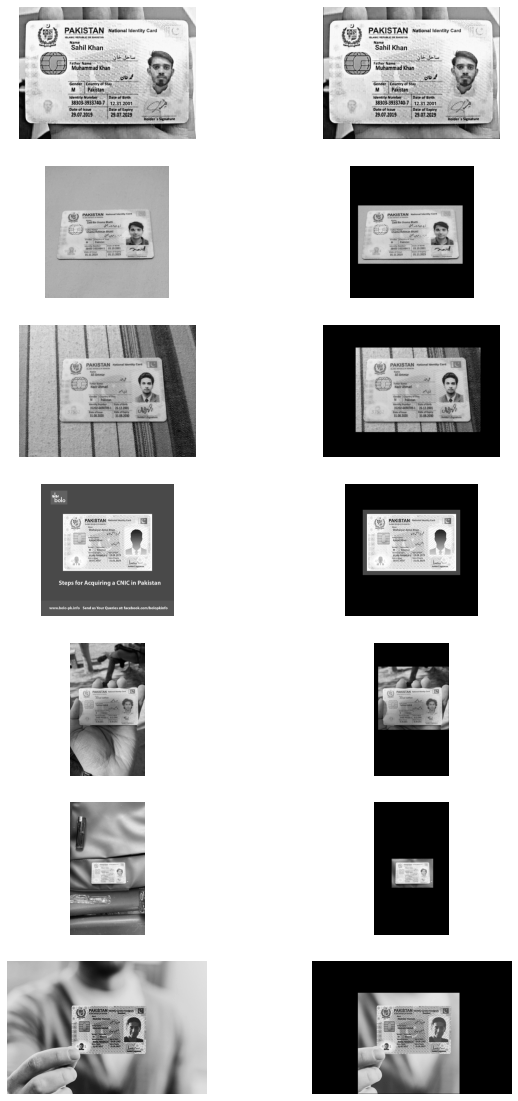

In [158]:
fig = plt.figure(figsize=(10, 20))

rows = len(band)
columns = 2

count = 0
for i in range(len(band)):
    count+= 1
    fig.add_subplot(rows, columns, count)
    plt.imshow(img[i],'gray')
    plt.axis('off')
    count+=1
    fig.add_subplot(rows, columns, count)
    plt.imshow(band[i],'gray')
    plt.axis('off')